In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [64]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [124]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, ytr = build_dataset(words[:n1])
Xdev, ydev = build_dataset(words[n1:n2])
Xte, yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
C = torch.randn((27, 2))

In [7]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [8]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [33]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [35]:
h

tensor([[-0.8896,  0.9999, -0.3339,  ...,  0.8826, -0.8145, -0.6777],
        [-0.3168,  0.9997, -0.1670,  ...,  0.8667, -0.4385,  0.0514],
        [-0.9989,  0.9949,  0.9945,  ..., -0.9475, -0.9991, -0.9988],
        ...,
        [ 0.9170, -0.9985, -0.9399,  ..., -0.8707, -0.5143,  0.9995],
        [-0.4287,  0.9015, -0.9665,  ..., -0.2235,  0.8268, -0.6937],
        [-0.5313,  0.3296,  0.1225,  ..., -0.9888, -0.9749, -0.9840]])

In [37]:
h.shape

torch.Size([32, 100])

In [39]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [40]:
logits = h @ W2 + b2

In [41]:
logits.shape

torch.Size([32, 27])

In [42]:
counts = logits.exp()

In [43]:
prob = counts / counts.sum(1, keepdim=True)

In [44]:
prob.shape

torch.Size([32, 27])

In [48]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(19.2894)

In [49]:
# ---------- respectable ----------

In [125]:
Xtr.shape, ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [195]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [196]:
sum(p.nelement() for p in parameters)

11897

In [197]:
for p in parameters:
    p.requires_grad = True

In [198]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [199]:
lri = []
lossi = []
stepi = []

In [200]:
for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # stats track
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(loss.item())

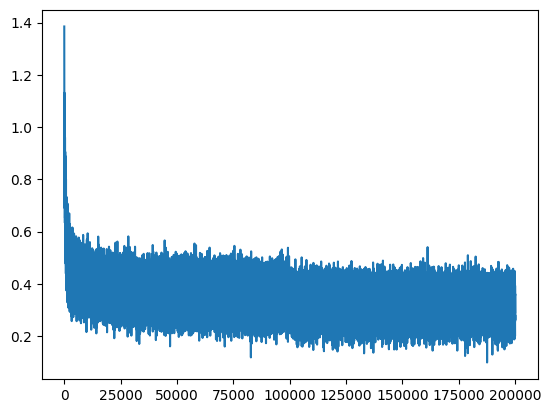

In [201]:
plt.plot(stepi, lossi)

In [202]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ytr)
loss

tensor(2.1234, grad_fn=<NllLossBackward0>)

In [203]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, ydev)
loss

tensor(2.1639, grad_fn=<NllLossBackward0>)

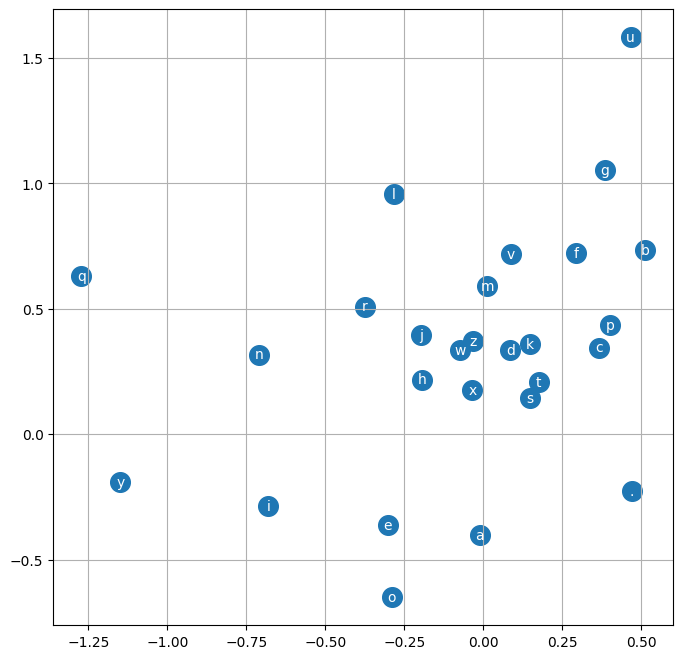

In [177]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [205]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
ambrie.
khy.
mili.
taty.
salana.
emmahnen.
delynn.
jareen.
nez.
kea.
chaiiv.
kaleigh.
ham.
pora.
quinn.
shous.
alian.
quinne.
ogiearyn.
